# Espace Note

In [ ]:
# regarder si des couleurs sont atypiques attirent des comportements atypiques chez certains clients

# établir une répartition des types d'articles achetés dans la période de l'année où l'on doit faire
# la prédiction. Il faut faire de même pour les couleurs de saison et vérifier si elles sont différentes
# d'une année sur l'autre pour évaluer la mode. Il faut aussi voir la couleur à la mode pour l'année

# établir le profil des clients en fonction des types d'objets achetés. Puis par série ou non ?

# établir une liste des articles qui s'achètent en simple, double, triple

In [ ]:
# Hypothèse 1 On va retirer les clients qui commandent plus que 99% de clients

In [313]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Espace travail

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time 
import sys
import csv
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
import datetime
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
os.chdir('drive/MyDrive/Formation/Projet 8')

In [5]:
pickle_in = open('sample_cust_df.pickle','rb')
sample_cust_df = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('df_info.pickle','rb')
df_info = pickle.load(pickle_in)
pickle_in.close()
pickle_in = open('df_sample_cust.pickle','rb')
df_sample_cust = pickle.load(pickle_in)
pickle_in.close()
# pickle_in = open('df_sample.pickle','rb')
# df_sample = pickle.load(pickle_in)
# pickle_in.close()

In [6]:
meta_art = pd.read_csv('articles.csv',dtype={'article_id': str})
meta_cust = pd.read_csv('customers.csv')
sub_format = pd.read_csv('sample_submission.csv')
df = pd.read_csv('transactions_train.csv',dtype={'article_id': str})

In [7]:
df['sales_channel_id'] = df['sales_channel_id'].astype('int8')

In [8]:
meta_art.drop([
               'graphical_appearance_no','product_type_no','colour_group_code',\
               'index_code','index_group_no','product_code',\
               'perceived_colour_value_id','perceived_colour_master_id',\
               'department_no','section_no','garment_group_no'],\
              axis=1,inplace=True)

In [9]:
# Calculating the threshold of number of orders max to represent 99% of the pop
# The last remaining 1% orders much more than the average customer and will be 
# removed from data to quicken the runtimes
nb_orders = df.groupby('customer_id')['t_dat'].nunique()
seuil = 0.0
nb_purchase = 0
while seuil < 0.99:
    nb_purchase += 1
    seuil=len(nb_orders[nb_orders<(nb_purchase+1)])/len(nb_orders)
print(nb_purchase)
cust_too_many_commands =nb_orders[nb_orders>nb_purchase].index
df = df[~df['customer_id'].isin(cust_too_many_commands)]

45


# Definition of the first time client: How can we do better than randomly chosing an article

In [232]:
# we make a list of the 12 most populars items as we can predict up to 12 items
# for a customer with no penalty
most_bought_2020 = df[df['t_dat'] > '2020-08-22'].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12)
most_bought_2020 = df[df['t_dat'] > '2020-08-22'].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12)

# Pattern related to the time of the year

In [14]:
df_info = df.merge(meta_art,how='left',on='article_id')

In [15]:
# we are making our tests on 10000 customers
# we create the dataframe that will hold the information of customers
# we create the sub DataFrame of these customers df_sample

random.seed(123)
sample_cust = random.sample(set(df_info['customer_id']),k = 10000)
sample_cust_df = pd.DataFrame(index=sample_cust)
df_sample = df_info[df_info['customer_id'].isin(sample_cust)]
sample_cust_df['customer_id']=sample_cust_df.index

In [233]:
# list of colour previously bought
# nb of purchases over the 2 years
# type of clothing purchases

sample_cust_df['colour_bought'] = df_sample.groupby('customer_id')\
['perceived_colour_master_name'].unique()
sample_cust_df['nb_purchase'] = df_sample.groupby('customer_id')\
['article_id'].count()
sample_cust_df['type_of_clothing'] = df_sample.groupby('customer_id')\
['product_group_name'].unique()
sample_cust_df['appearance'] = df_sample.groupby('customer_id')\
['graphical_appearance_name'].unique()

In [17]:
# the goal here is to make a conformity score, to see if the customer buys the
# most popular 'something' (colour,type of clothing)
def conformity_score(category):
  sample_cust_df['conformity_'+category] = 0
  col_fr = df_info[category].value_counts(normalize=True)
  t0=time()
  for count,cust in enumerate(sample_cust_df.index):  
    conf = 0
    df_temp = df_sample[df_sample['customer_id']==cust]
    for colour in col_fr.index:
      conf = conf + float(((df_temp[category]==colour).sum()))*float(col_fr[col_fr.index==colour])    
    conf = conf/float(sample_cust_df[sample_cust_df.index==cust]['nb_purchase'])  
    sample_cust_df.loc[cust,'conformity_'+category]=conf 

#took 6 minutes like must be a way to improve the speed

In [234]:
conformity_score('perceived_colour_master_name')
conformity_score('product_group_name')
conformity_score('graphical_appearance_name')
sample_cust_df['conformity_perceived_colour_master_name'] = sample_cust_df['conformity_perceived_colour_master_name']/sample_cust_df['conformity_perceived_colour_master_name'].mean()
sample_cust_df['conformity_product_group_name'] = sample_cust_df['conformity_product_group_name']/sample_cust_df['conformity_product_group_name'].mean()
sample_cust_df['conformity_graphical_appearance_name'] = sample_cust_df['conformity_graphical_appearance_name']/sample_cust_df['conformity_graphical_appearance_name'].mean()
# a value higher than 1, means that the customer is buying the most standard articles and a value below means the customer is buying least standard articles

In [20]:
sample_cust_df['average_buy'] = df_sample.groupby('customer_id')['price'].mean()
sample_cust_df['std_buy'] = df_sample.groupby('customer_id')['price'].std()
sample_cust_df['max_budget'] = df_sample.groupby('customer_id')['price'].max()

In [ ]:
df_temp_Y = pd.DataFrame(df_sample[df_sample['t_dat'] >'2020-09-14'])
df_3_weeks = df_info[(df_info['t_dat']>'2020-09-01')&(df_info['t_dat']<='2020-09-14')]

In [ ]:
def article_selection(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_cust_df.loc[cust,'max_budget']]
    # we remove articles with perceived colour never bought by the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_cust_df.loc[cust,'colour_bought']))]['article_id']))
    # we remove articles out of the product group of the customer
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_cust_df.loc[cust,'type_of_clothing']))]['article_id']))
    temp_list = temp_list.intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_cust_df.loc[cust,'appearance']))]['article_id']))   
    temp_list1 = temp_list.intersection(set(actually_bought))
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [269]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  wide_list_popular_item_df['price_estimated']=0
  for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      article_selection)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list

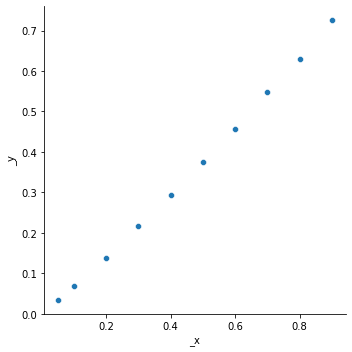

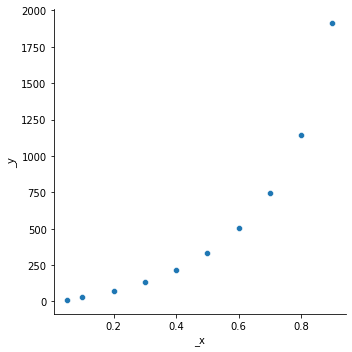

In [270]:
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

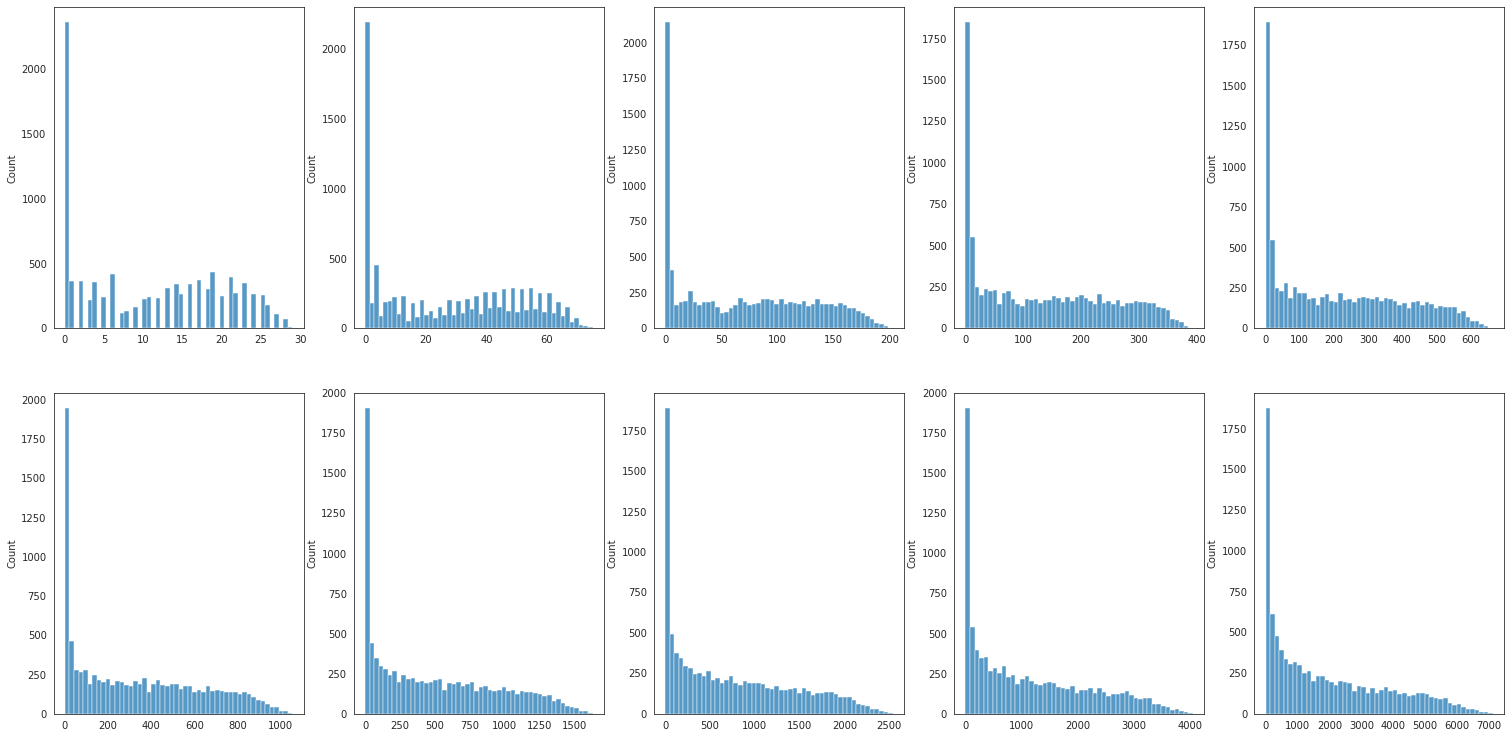

In [286]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [320]:
def art_sel_budget(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles that have an estimated price higher than max budget
    temp_list = temp_list[temp_list['price_estimated']<sample_cust_df.loc[cust,'max_budget']] 
    temp_list1 = set(temp_list.index).intersection(set(actually_bought))
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))   

In [321]:
def art_sel_colour(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df
    # we remove articles with perceived colour never bought by the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['perceived_colour_master_name'].isin(set(sample_cust_df.loc[cust,'colour_bought']))]['article_id'])) 
    temp_list1 = temp_list.intersection(set(actually_bought)) 
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [344]:
def art_sel_typecloth(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    # we remove articles out of the product group of the customer
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['product_group_name'].isin(set(sample_cust_df.loc[cust,'type_of_clothing']))]['article_id']))      
    temp_list1 = temp_list.intersection(set(actually_bought))    
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))

In [345]:
def art_sel_appearance(cust): 
    actually_bought = df_temp_Y[df_temp_Y['customer_id']==cust]['article_id']    
    temp_list = wide_list_popular_item_df  
    temp_list = set(temp_list.index).intersection(set(meta_art_pop[meta_art_pop['graphical_appearance_name'].isin(set(sample_cust_df.loc[cust,'appearance']))]['article_id']))   
    temp_list1 = temp_list.intersection(set(actually_bought))   
    return(len(temp_list1),len(set(actually_bought)),len(temp_list))  

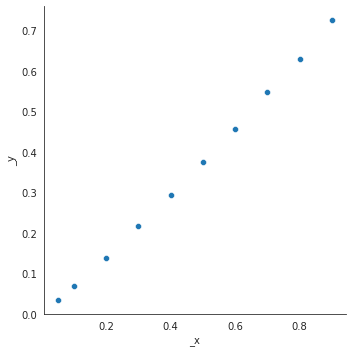

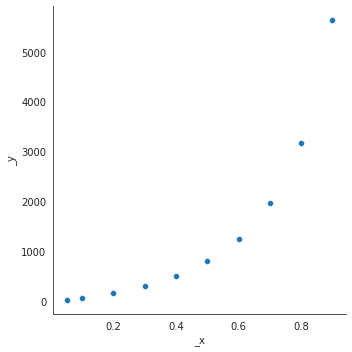

In [310]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  wide_list_popular_item_df['price_estimated'] = 0
  for item in wide_list_popular_item_df.index:
    wide_list_popular_item_df.loc[item,'price_estimated'] = \
    df_3_weeks[df_3_weeks['article_id']==item]['price'].mean()
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers. We divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list. we calculate c2 the number of articles
  # in our restricted list on average we calculate c3, the distribution of
  # of number of restricted articles per customer.
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_budget)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

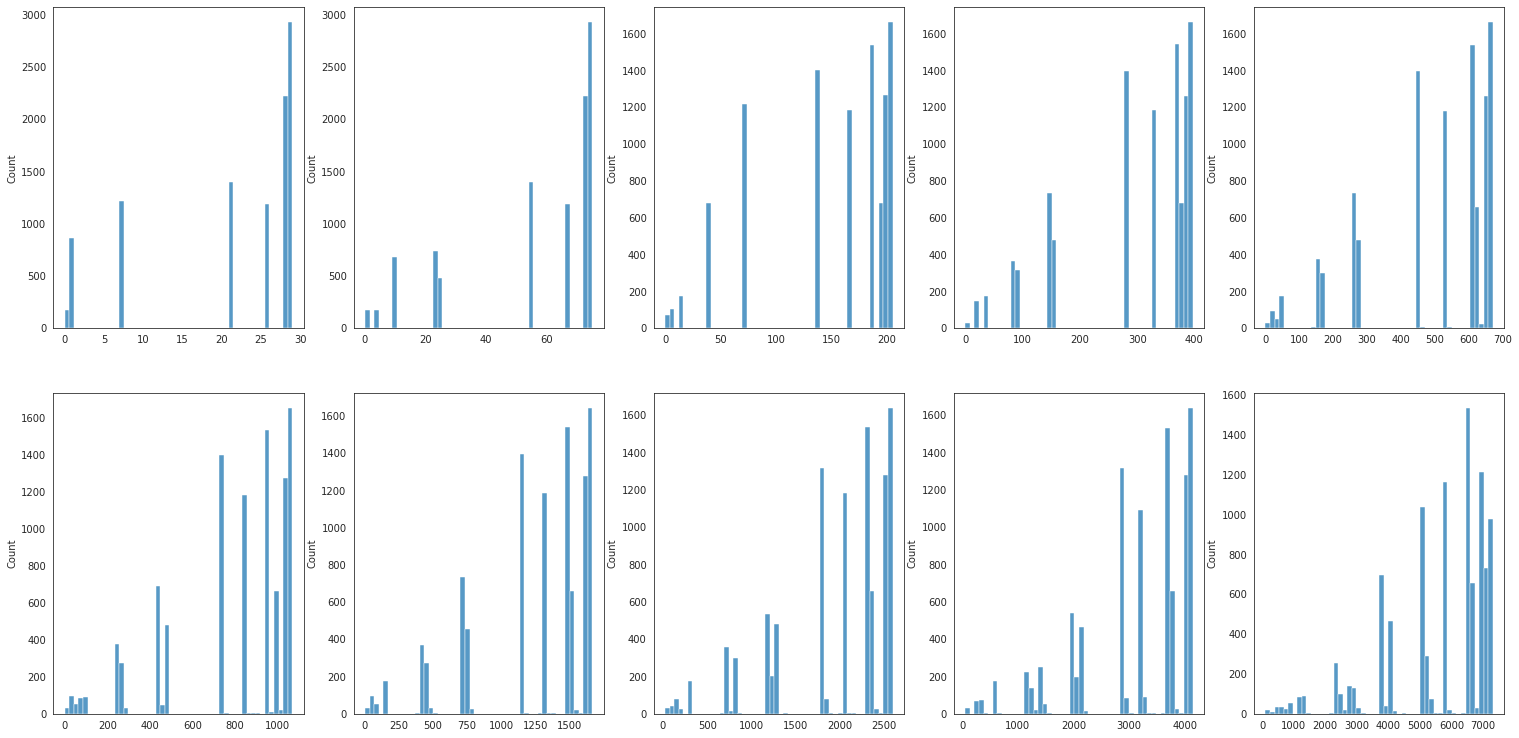

In [292]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [311]:
count1

[0.03434225844004657,
 0.06752037252619325,
 0.13853317811408614,
 0.21653084982537835,
 0.2939464493597206,
 0.3742724097788126,
 0.45692665890570433,
 0.5488940628637952,
 0.629802095459837,
 0.7252619324796274]

In [312]:
count2

[21.6936,
 57.4244,
 151.6171,
 300.2459,
 503.0872,
 802.8776,
 1247.0668,
 1967.841,
 3161.3478,
 5628.8758]

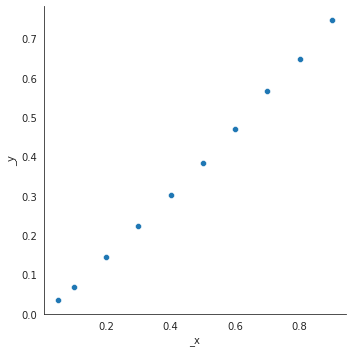

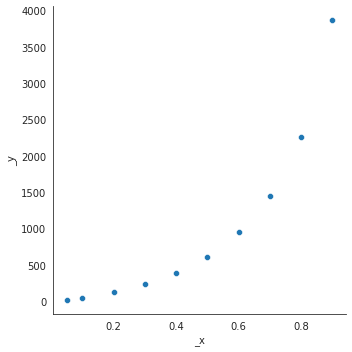

In [316]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_colour)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

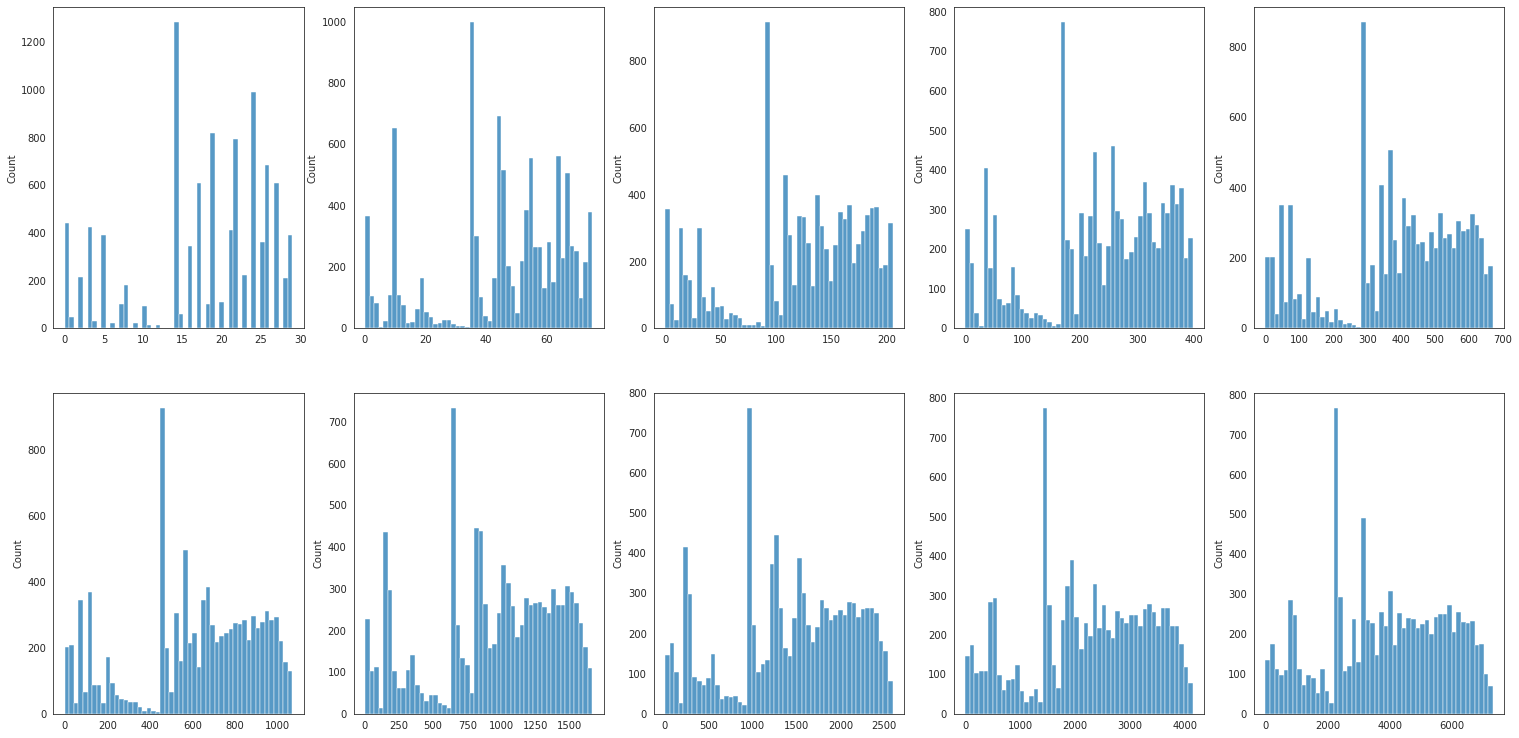

In [317]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [318]:
count1

[0.03550640279394645,
 0.06868451688009314,
 0.14377182770663563,
 0.2240977881257276,
 0.30267753201396974,
 0.3841676367869616,
 0.46973224679860304,
 0.5657741559953434,
 0.6490104772991852,
 0.7462165308498254]

In [319]:
count2

[17.741,
 44.9167,
 122.0277,
 234.5742,
 388.7612,
 614.101,
 945.6309,
 1441.1336,
 2255.4784,
 3866.7401]

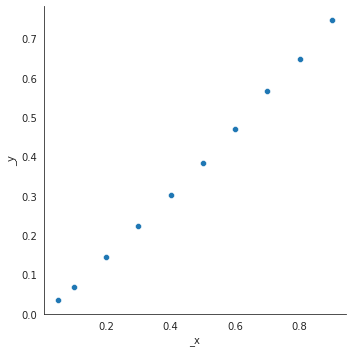

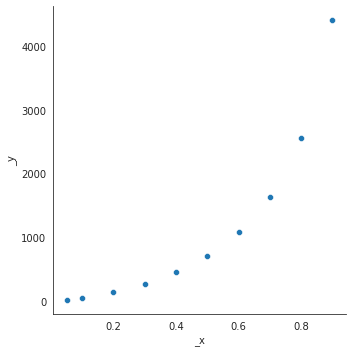

In [347]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_typecloth)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

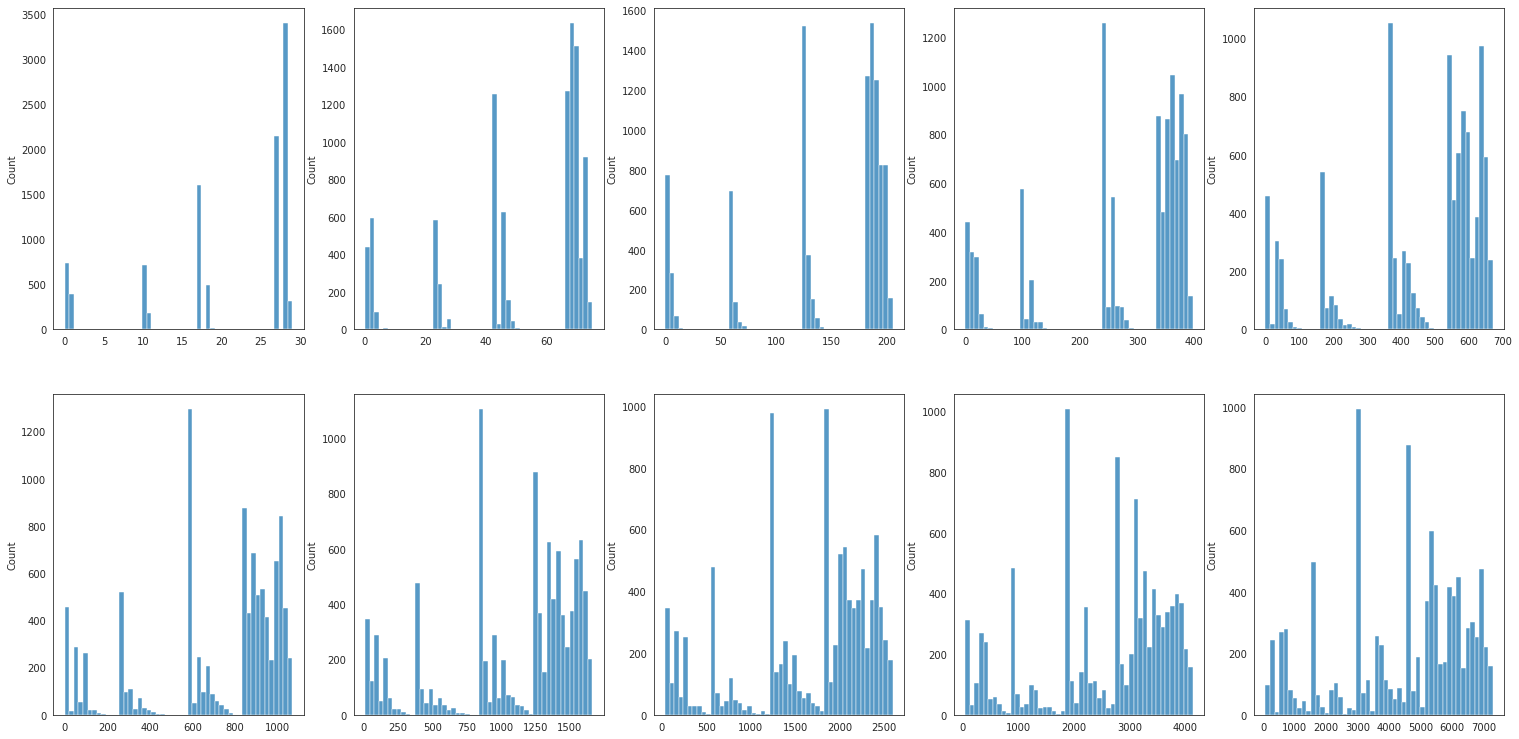

In [303]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [304]:
count1

[0.03550640279394645,
 0.06868451688009314,
 0.14377182770663563,
 0.2240977881257276,
 0.30267753201396974,
 0.3841676367869616,
 0.46973224679860304,
 0.5657741559953434,
 0.6490104772991852,
 0.7462165308498254]

In [305]:
count2

[20.823,
 52.1019,
 143.6103,
 276.2883,
 453.6262,
 714.1889,
 1085.0904,
 1637.5409,
 2557.7932,
 4403.0067]

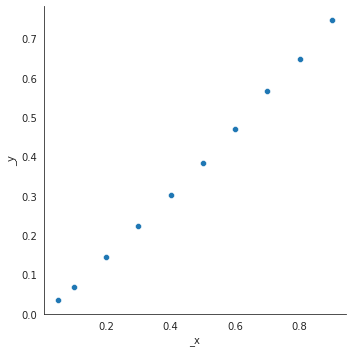

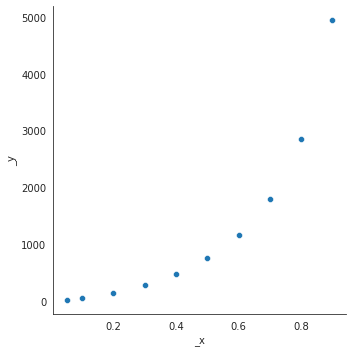

In [346]:
# we define the items needed to reach the threshold th of the total number
# of sales. These are the most popular items.
th_list = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
count1 = []
count2 = []
count3 = []
for th in th_list:
  nb = (df_3_weeks['article_id'].value_counts(normalize=True).cumsum()<th).sum() 
  wide_list_popular_items = df_3_weeks['article_id'].value_counts(
      normalize=True).head(nb).index.tolist()
  wide_list_popular_item_df = pd.DataFrame(index=wide_list_popular_items)
  # we calculate the estimated price of each of these items
  # (sales can change price)
  # we create a subdataframe restricted to the popular item defined by th
  meta_art_pop = meta_art[meta_art['article_id'].isin(wide_list_popular_items)]
  # we calculate c1 the number of articles bought and in our restricted
  # list defined in article_selection for all customers we divide c1 by the 
  # number of purchases to define the maximal precision if we chose the
  # articles in our restricted list we calculate c2 the number of articles
  # in our restricted list on average we calculate c3 which is c1/c2 the
  # required 'precision' to find the good articles in our list  
  sample_cust_df['possible_good_guess'] = sample_cust_df['customer_id'].apply(
      art_sel_appearance)  
  c1 = 0
  c2 = 0
  c3 = []
  for i in sample_cust_df['possible_good_guess']:    
    c1 += i[0]
    c2 += i[2]     
    c3.append(i[2])     
  c2 = c2/len(sample_cust_df['customer_id'])  
  count1.append(c1/len(df_temp_Y['article_id']))
  count2.append(c2)
  count3.append(c3)  
  # count1 is max precision that we can expect if the algorithm
  # has 100% precision
  # count2 is the number of articles per customer on average
  # count3 is the number of articles in the restricted list
sns.relplot(x=th_list,y=count1)
sns.relplot(x=th_list,y=count2)

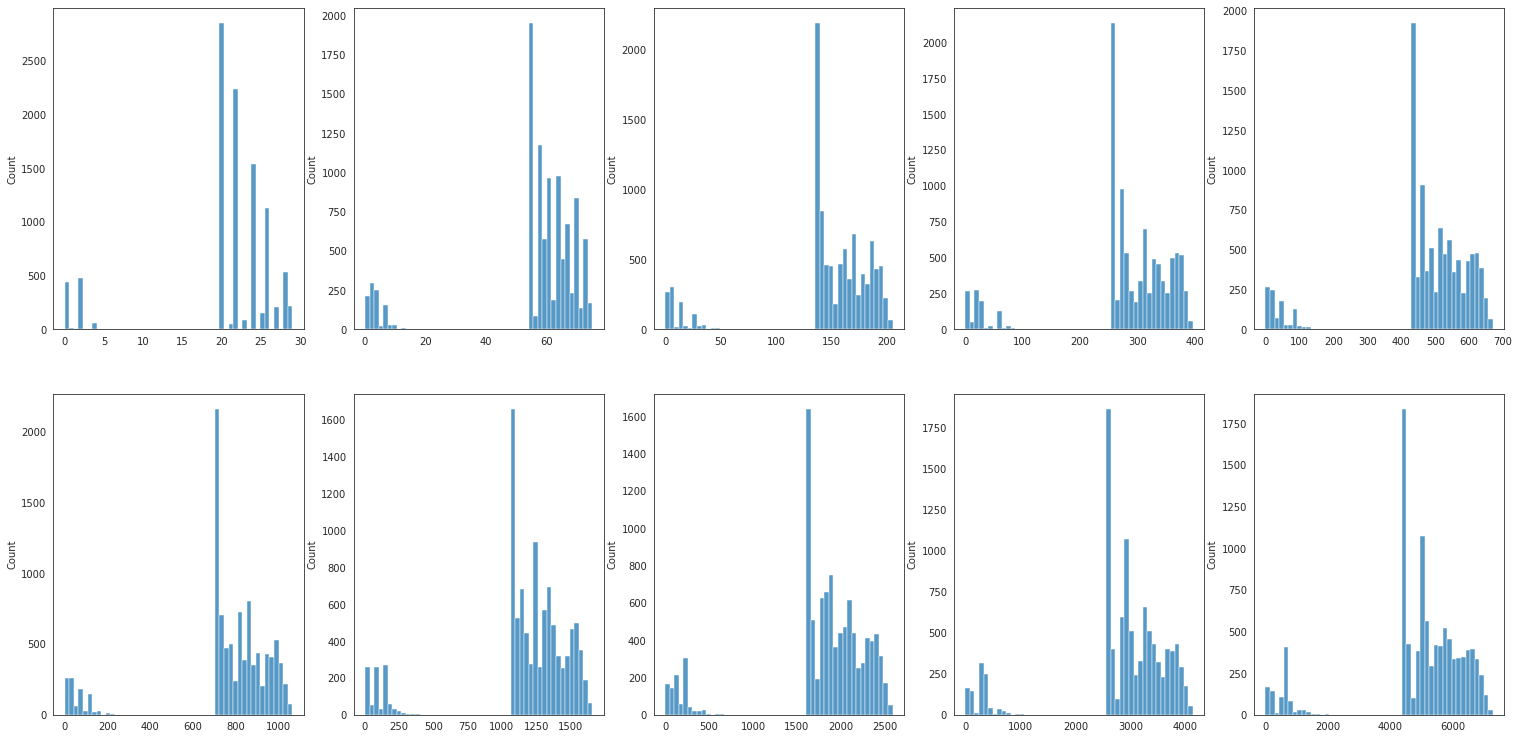

In [307]:
sns.set_style("white")
fig, axes = plt.subplots(2, 5, figsize=(26, 13))
for count,value in enumerate(count3):
  plt.subplot(2,5,count+1)
  sns.histplot(value,bins=50)
# We can see that the method to reduce the list of candidate 
# mostly put occasional customers to 0 no matter the initial amount.

In [308]:
count1

[0.03550640279394645,
 0.06868451688009314,
 0.14377182770663563,
 0.2240977881257276,
 0.30267753201396974,
 0.3841676367869616,
 0.46973224679860304,
 0.5657741559953434,
 0.6490104772991852,
 0.7462165308498254]

In [309]:
count2

[20.7271,
 56.0863,
 145.4567,
 279.3143,
 470.5949,
 755.6025,
 1169.8446,
 1797.1264,
 2855.0558,
 4939.9009]

In [ ]:
# we see that colour is the one reducing the average number of articles the
# fastest then it's typecloth, appearance and budget